# Topic Modelling of MLA conference abstracts

[Topic modelling](https://en.wikipedia.org/wiki/Topic_model) computationally analyzes topics within texts. By looking at where and when words occure, topics and their percentages can be predicted. LDA (Latent Dirichlet Allocation) is one method of topic modelling. It is a statistical approach that calculates the chances of words appearing in certain contexts (within documents, or near other words). [Here is a simple introduction to LDA](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d).
 
#### What does this code do?

I'm trying to extract topics from the Medical Library Association's conference abstract dataset. What topics have we talked about over the years? Have the topics changed thorugh time?
 
#### References

Almost all of this code is taken or adapted from these excellent tutorials at Machine Learning Plus:

[Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

[Topic modeling visualization – How to present the results of LDA models?](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

### Import python libraries

In [2]:
import os
import numpy as np # numpy is for working with arrays
import pandas as pd # pandas is a popular data science library
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)

import gensim # gensim is a topic modelling library
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy # spacy is a natural language processing library

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Import data

In [150]:
# the file is downloadable and browsable at http://bit.ly/mlameetings
mla = pd.read_csv("mla.csv", encoding="latin1")

### Preprocess the text: remove stop words, strip away unnecessary characters, use natural language processing to remove unnecessary words, create useful bigrams

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords #nltk is another natural language processing library
stop_words = stopwords.words('english')

# add to the stop words list to remove structured abstract headings
stop_words.extend(["objective", "objectives", "method", "methods", "results", "result", "conclusion"\
                   , "conclusions", "discussion", "poster", "purpose", "presentation", "nan"])

In [5]:
# convert to list
titles_abstracts = mla[["Title", "Abstract"]].values.tolist()

In [6]:
# clean up using gensim simple preprocess (convert to lowercase, remove punctuation, etc)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

titles_abstracts = list(sent_to_words(titles_abstracts))

In [7]:
# Build the bigram and trigram models
# bigrams are groups of two words that occur together (e.g. "information literacy"), trigrams are groups of three words
bigram = gensim.models.Phrases(titles_abstracts, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[titles_abstracts], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# lemmatization is converting words to their roots (e.g. "users", "used", "using" -- > "use")
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
titles_abstracts = remove_stopwords(titles_abstracts)

# Form Bigrams
titles_abstracts_bigrams = make_bigrams(titles_abstracts)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
titles_abstracts_lemmatized = lemmatization(titles_abstracts_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


### Create a dictionary (processed words and how many times they appear) and a corpus (all the processed words)

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(titles_abstracts_lemmatized)

# Create Corpus
texts = titles_abstracts_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

### Get Mallet (the package that actually models the topics). You need to download it from the link below to use it with Gensim in Python.

### Download the Mallet file: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [154]:
# updating environment, change this to reflect where mallet is on your own computer
%env 'MALLET_HOME': "mallet-2.0.8"
os.environ.update({'MALLET_HOME':r"mallet-2.0.8"})

env: 'MALLET_HOME':="mallet-2.0.8"


In [155]:
# also change this to point to this same directory on your own computer
mallet_path = "mallet-2.0.8/bin/mallet"

In [12]:
# create a gensim LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=27, #more on choosing a number of topics below. don't forget to update here
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True) 

# change to a mallet model, mallet uses a different algorithm and in this case is giving better topics
# don't forget to update # of topics here
# setting the random seed ensures that this is reproducible
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=27, id2word=id2word, random_seed=1) 

doc_lda = lda_model[corpus]

In [13]:
# view the mallet topics
print(ldamallet.show_topics(formatted=True))

[(15, '0.051*"class" + 0.045*"online" + 0.035*"session" + 0.034*"training" + 0.032*"learn" + 0.031*"workshop" + 0.027*"instruction" + 0.021*"tutorial" + 0.019*"teach" + 0.018*"evaluation"'), (18, '0.217*"resource" + 0.084*"information" + 0.035*"provide" + 0.034*"support" + 0.032*"guide" + 0.028*"access" + 0.021*"include" + 0.019*"portal" + 0.019*"develop" + 0.018*"online"'), (25, '0.020*"medical" + 0.018*"medicine" + 0.015*"veterinary" + 0.015*"international" + 0.015*"disease" + 0.015*"human" + 0.013*"animal" + 0.012*"global" + 0.011*"country" + 0.010*"alternative"'), (16, '0.083*"health" + 0.072*"public" + 0.063*"community" + 0.044*"project" + 0.030*"outreach" + 0.022*"national" + 0.022*"state" + 0.021*"training" + 0.021*"local" + 0.019*"access"'), (21, '0.140*"base" + 0.090*"evidence" + 0.076*"practice" + 0.034*"medicine" + 0.030*"literature" + 0.025*"knowledge" + 0.025*"ebm" + 0.023*"clinical" + 0.023*"develop" + 0.019*"skill"'), (2, '0.087*"study" + 0.048*"analysis" + 0.043*"datum"

In [14]:
# Calcuate the coherence score for the mallet topics we just identified
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4652673292618452


### Detour to figure out how many topics are optimal. Too many, they overlap and are too specific to really represent overall trends; too few, and we miss identifying key themes. We can check the coherence scores of topics to see how similar the words in each topic are to each other.

### These code sections are in RawNB Convert form, change them to Code in the dropdown menu at the top if you want to be able to run these for yourself.

### If, based on this next section, you change your mind about the optimal number of topics, don't forget to update the arguments for the lda_model and ldamallet variables above.

### Visualize with pyLDAvis. This is a great way to interact with the topics.

In [15]:
# switch the mallet model back to a gensim model as pyLDAvis doesn't work directly with mallet
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [152]:
# code gives a warning (was supposed to have been fixed in the latest version of pyLDAvis) but it still works
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis)

C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] 

In [153]:
# save the visualization
pyLDAvis.save_html(vis, 'mla_topics.html')

### Look at the dominant topic for each MLA abstract.

In [17]:
# go through the abstracts and select the most dominant topic in each abstract
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=titles_abstracts_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=titles_abstracts_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
#display(df_dominant_topic)

### Incorporate year data to see trends over time

In [18]:
# add years
df_dominant_topic["Year"] = mla["Year"]

# Show
#display(df_dominant_topic)

### Change the numerical topic codes to human-readable topics and adjust the formatting of the model data

In [19]:
# the model data is a list of tuples, each tuple is the topic number 
# along with the percentage of contribution that that topic makes to each record

# turning that into a formatted dataframe that has each topic as a column and the values are the percentages
    
tuples_as_df = pd.DataFrame(ldamallet[corpus])

# rename columns
tuples_as_df["Reference services"] = tuples_as_df[0].str[1]
tuples_as_df["Literature searching"] = tuples_as_df[1].str[1]
tuples_as_df["Research"] = tuples_as_df[2].str[1]
tuples_as_df["Academic outreach"] = tuples_as_df[3].str[1]
tuples_as_df["Publications"] = tuples_as_df[4].str[1]
tuples_as_df["Technology"] = tuples_as_df[5].str[1]
tuples_as_df["Collections"] = tuples_as_df[6].str[1]
tuples_as_df["Digital projects"] = tuples_as_df[7].str[1]
tuples_as_df["Professional development"] = tuples_as_df[8].str[1]
tuples_as_df["Librarian communities"] = tuples_as_df[9].str[1]
tuples_as_df["Professional issues"] = tuples_as_df[10].str[1]
tuples_as_df["Collaboration"] = tuples_as_df[11].str[1]
tuples_as_df["Academic instruction"] = tuples_as_df[12].str[1]
tuples_as_df["Health information"] = tuples_as_df[13].str[1]
tuples_as_df["Librarian roles"] = tuples_as_df[14].str[1]
tuples_as_df["Instructional design and delivery"] = tuples_as_df[15].str[1]
tuples_as_df["Community outreach"] = tuples_as_df[16].str[1]
tuples_as_df["Clinical contexts"] = tuples_as_df[17].str[1]
tuples_as_df["Information resources"] = tuples_as_df[18].str[1]
tuples_as_df["Patient education"] = tuples_as_df[19].str[1]
tuples_as_df["Academic contexts"] = tuples_as_df[20].str[1]
tuples_as_df["Evidence based practice"] = tuples_as_df[21].str[1]
tuples_as_df["Data management"] = tuples_as_df[22].str[1]
tuples_as_df["Websites"] = tuples_as_df[23].str[1]
tuples_as_df["Changes and improvements"] = tuples_as_df[24].str[1]
tuples_as_df["Other health contexts"] = tuples_as_df[25].str[1]
tuples_as_df["Surveys"] = tuples_as_df[26].str[1]

tuples_as_df.drop(tuples_as_df.iloc[:, 0:27], inplace=True, axis=1)
#display(tuples_as_df)


### Merge the model's full data with the dominant topic dataframe from before. Now all data is in one place

In [20]:
all_topics = pd.concat([tuples_as_df, df_dominant_topic], axis=1)
#display(all_topics)
#all_topics.to_csv("all topics.csv")

### Rename the dominant topics in the cells from numbers to topic names

In [21]:
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 0.0] = "Reference services"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 1.0] = "Literature searching"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 2.0] = "Research"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 3.0] = "Academic outreach"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 4.0] = "Publications"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 5.0] = "Technology"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 6.0] = "Collections"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 7.0] = "Digital projects"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 8.0] = "Professional development"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 9.0] = "Librarian communities"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 10.0] = "Professional issues"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 11.0] = "Collaboration"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 12.0] = "Academic instruction"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 13.0] = "Health information"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 14.0] = "Librarian roles"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 15.0] = "Instructional design and delivery"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 16.0] = "Community outreach"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 17.0] = "Clinical contexts"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 18.0] = "Information resources"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 19.0] = "Patient education"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 20.0] = "Academic contexts"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 21.0] = "Evidence based practice"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 22.0] = "Data management"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 23.0] = "Websites"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 24.0] = "Changes and improvements"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 25.0] = "Other health contexts"
all_topics["Dominant_Topic"].loc[all_topics["Dominant_Topic"] == 26.0] = "Surveys"


#display(all_topics)

C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Manually check a random sample to make sure the data is correct

### Plot topics that most dominate presentations

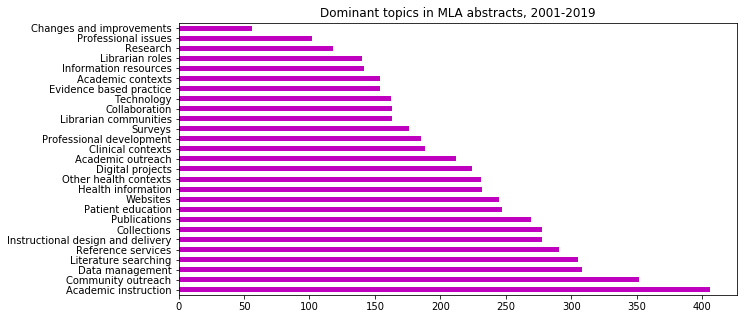

In [23]:
# pull out the dominant topic column from the dataframe, count each occurence of each topic, and sort
all_topics_dominant = all_topics["Dominant_Topic"].value_counts()
all_topics_dominant = all_topics_dominant.sort_values(ascending = False)
# transpose so that the topics are on the y axis
all_topics_dominant = all_topics_dominant.T

# plot
ax = all_topics_dominant.plot.barh(figsize=(10,5), color=["m"], title="Dominant topics in MLA abstracts, 2001-2019")

# replace the topics numbers with text labels

fig = ax.get_figure()
fig.savefig("most dominant topics in each mla abstract", dpi =1000)

### Plot distribution of the topic percentages through time

In [102]:
# create new dataframe

topics_over_time = all_topics.groupby(['Year'])[["Reference services", "Literature searching", "Research", "Academic outreach", 
                                                 "Publications", "Technology", "Collections", "Digital projects", "Professional development", 
                                                 "Librarian communities", "Professional issues", "Collaboration", "Academic instruction", 
                                                 "Health information", "Librarian roles", "Instructional design and delivery", "Community outreach", 
                                                 "Clinical contexts", "Information resources", "Patient education", "Academic contexts", 
                                                 "Evidence based practice", "Data management", "Websites", "Changes and improvements", 
                                                 "Other health contexts", "Surveys"]].sum()
#display(topics_over_time)
#topics_over_time.to_csv("topics over time.csv")

#### Area plot: this plot shows the percentage of each topic within each year's total amount of content

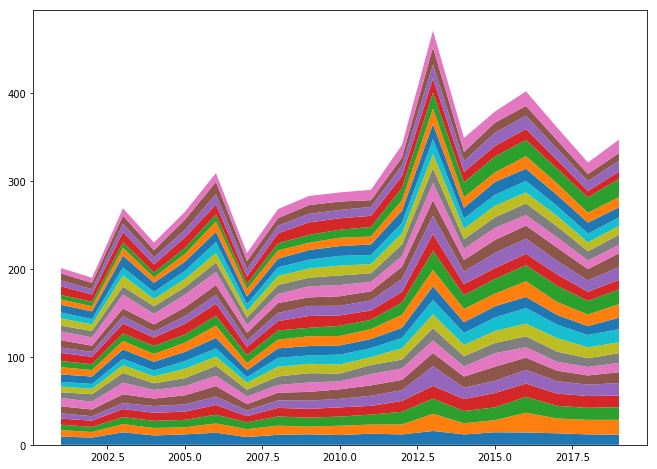

In [124]:
fig, ax = plt.subplots()
fig.set_size_inches(11,8)

y = [topics_over_time["Reference services"], 
             topics_over_time["Literature searching"], 
             topics_over_time["Research"],
             topics_over_time["Academic outreach"], 
             topics_over_time["Publications"], 
             topics_over_time["Technology"], 
             topics_over_time["Collections"], 
             topics_over_time["Digital projects"], 
             topics_over_time["Professional development"], 
             topics_over_time["Librarian communities"], 
             topics_over_time["Professional issues"], 
             topics_over_time["Collaboration"], 
             topics_over_time["Academic instruction"], 
             topics_over_time["Health information"], 
             topics_over_time["Librarian roles"], 
             topics_over_time["Instructional design and delivery"], 
             topics_over_time["Community outreach"], 
             topics_over_time["Clinical contexts"], 
             topics_over_time["Information resources"], 
             topics_over_time["Patient education"], 
             topics_over_time["Academic contexts"], 
             topics_over_time["Evidence based practice"], 
             topics_over_time["Data management"], 
             topics_over_time["Websites"], 
             topics_over_time["Changes and improvements"], 
             topics_over_time["Other health contexts"], 
             topics_over_time["Surveys"]]

ax.stackplot(topics_over_time.index, y)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### 100% area plot: this plot normalizes the topics to show the relative percentage of each topic over all 19 years

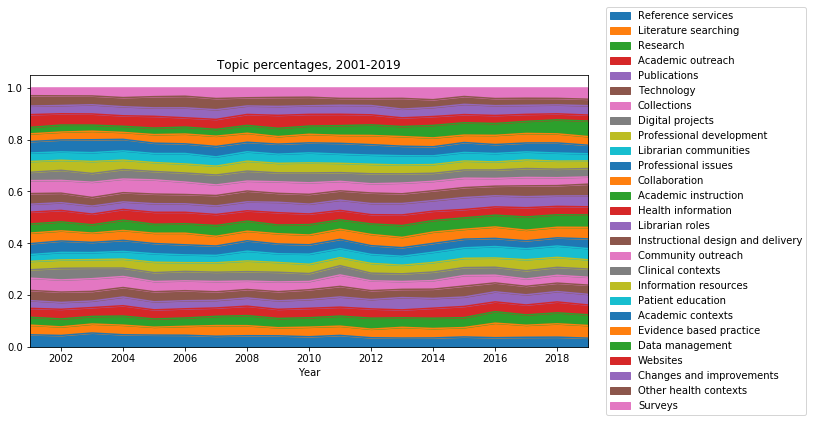

In [100]:
topics_over_time_plot = topics_over_time.divide(topics_over_time.sum(axis=1), axis=0)

ax2 = topics_over_time_plot.plot.area(figsize=(10,5), title="Topic percentages, 2001-2019")
fig2 = ax2.get_figure()
ax2.legend(loc='center right', bbox_to_anchor=(1.4,.5))
fig2.savefig("area plot.png", dpi =1000)

#### single topic plot - relative - this plot shows what % per year this one topic represents compared to the other 26 topics

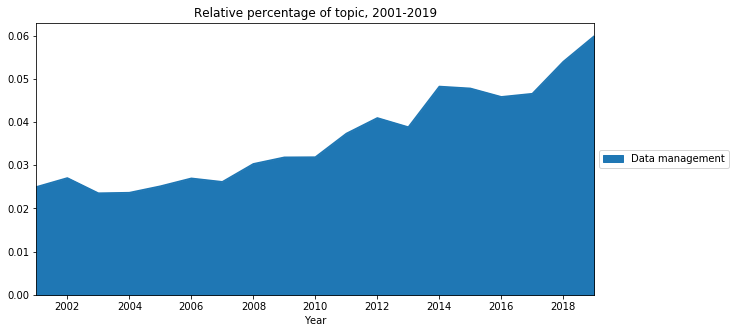

In [145]:
ax3 = topics_over_time_plot["Data management"].plot.area(figsize=(10,5), title="Relative percentage of topic, 2001-2019")
fig3 = ax3.get_figure()
ax3.legend(loc='center right', bbox_to_anchor=(1.25,.5))

#### single topic plot - absolute - this plot shows the topic's % per year representation in all meeting content

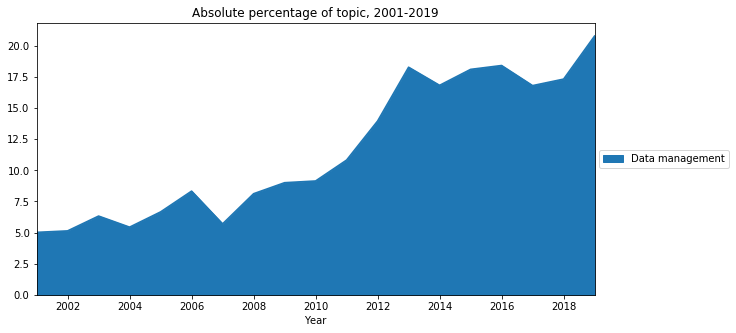

In [147]:
ax4 = topics_over_time["Data management"].plot.area(figsize=(10,5), title="Absolute percentage of topic, 2001-2019")
fig4 = ax4.get_figure()
ax4.legend(loc='center right', bbox_to_anchor=(1.25,.5))

### Looking at the topics with the biggest changes

#### Print the maximum absolute value and the year in which it happened for each topic (i.e. the actual topic representation %)

In [138]:
# year when each topic was most represented - absolutely
print(topics_over_time.max())
print(topics_over_time.idxmax())

print(topics_over_time.min())
print(topics_over_time.idxmin())

Reference services          15.729510
Literature searching        22.562770
Research                    17.916897
Academic outreach           16.414584
Publications                22.368553
Technology                  16.109174
Collections                 15.339704
Digital projects            13.929208
Professional development    15.722573
Librarian communities       17.744353
                              ...    
Clinical contexts           16.770537
Information resources       16.160861
Patient education           16.826454
Academic contexts           17.314106
Evidence based practice     17.477558
Data management             20.799873
Websites                    15.829975
Changes and improvements    15.894111
Other health contexts       19.532681
Surveys                     19.135091
Length: 27, dtype: float64
Reference services          2013
Literature searching        2016
Research                    2016
Academic outreach           2015
Publications                2013
Technology

#### Print the maximum relative value and the year in which it happened for each topic (i.e. the topics have been normalized so that all 27 topics for each year add up to 1)

In [139]:
# years when each topic was most represented - relatively

print(topics_over_time_plot.max())
print(topics_over_time_plot.idxmax())

print(topics_over_time_plot.min())
print(topics_over_time_plot.idxmin())

Reference services          0.052915
Literature searching        0.056126
Research                    0.044569
Academic outreach           0.043310
Publications                0.047492
Technology                  0.042504
Collections                 0.049082
Digital projects            0.044908
Professional development    0.042564
Librarian communities       0.044140
                              ...   
Clinical contexts           0.038958
Information resources       0.046253
Patient education           0.040453
Academic contexts           0.049744
Evidence based practice     0.039741
Data management             0.059942
Websites                    0.050120
Changes and improvements    0.039595
Other health contexts       0.044854
Surveys                     0.045754
Length: 27, dtype: float64
Reference services          2003
Literature searching        2016
Research                    2016
Academic outreach           2015
Publications                2013
Technology                  201